In [2]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile #Process ramping file

## 0. Helper functions

In [2]:
def read_data_from_single_file(filepath):
    """Read in quench data from a given file, return a pandas dafa frame"""
    
    data_dict= {}
    
    with open(filepath) as f:
        content = f.readlines()
    #Remove`\n` at the end of each line
    content = [x.strip() for x in content]
    
    column_names = content[0].split(" ")
    data = [content[i].split("   ") for i in range(1, len(content))] 
    
    for i in range(len(column_names)):
        data_dict[column_names[i]] = [float(x[i]) for x in data]
        
    data_frame = pd.DataFrame(data_dict)
    
    return data_frame

def read_quench_data(area_path, quench_name):
    """
    Read the quench data from the provided file path, note that there are five quenches so we need to concatenate them together.
    Just need to provide the quench's name, for e.g: "./data/mqxfs1b.Quench.161011115654"
    """
    
    data_list = []
    
    
    num_file = 0 #Number of separate data files for this quench, assuming at least one
    
    for filename in os.listdir(area_path):
        if filename.startswith(quench_name) and not filename.endswith(".tar.gz"):
            #print("Reading file ... " + filename)
            if num_file == 0:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename)) #read first file separately
                except:
                    pass
            else:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename).drop(columns = ["time"])) #Time is already saved in the first file
                except:
                    pass
            num_file += 1
                                 
    #print("Total number of data files for {}: ".format(quench_name), num_file)
    
    if len(data_list) != 0:
        data = pd.concat(data_list, axis = 1) #Concatenate all data files together
        return data
    else:
        print("Returning None due to file errors in " + quench_name)
        return None

def read_all_quench_in_area(area_path):
    """
    Read all quench's files in the area and return a dictionary of different quench's data. name is the magnet's name
    """
    data = {}
    
    index = 1 #For indexing different quench

    for filename in os.listdir(area_path):
        if filename.endswith(".tar.gz"): 
            #print("Reading data from ... " + filename[0:-7])
            data[filename[0:-7]] = read_quench_data(area_path, filename[0:-7])
            index += 1
            
    #print("Completed. There are {} quenches in total.".format(str(index - 1)))
    
    return data

def plot_variables_with_time(data, variables = None, time_range = None):
    """
    Take a data frame, and plot all other variables with time.
    Optional argument: time_range to specify the range to plot, default is to plot all time. Example argument
    is (start_time, end_time)
    """
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    if variables:
        for variable in variables:
            plt.figure(figsize=(20,2))
            plt.plot(data["time"], data[variable])
            plt.title("Variable {}".format(variable))
            plt.show()
        
    else:      
        #If variables not specified then just plot all 
        for variable in data.columns[1:]:
            plt.figure(figsize=(25,2))
            plt.plot(data["time"], data[variable])
            plt.title("Variable {}".format(variable))
            plt.show()

def plot_statistics(data, variables = None, time_range = None, window = 100):
    """Take a data frame and plot the variable with its moving average and real data in the specified range, if
    variables are not specified then just plot all variables by default"""
    #Pickout the data
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    def plot_signal_and_statistics(variable):
        # Plotted by calculating Simple Moving Average (SMA)
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data[variable], label = "Signal with noise")
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).mean(),label = "Moving average")
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).min(),label = "Moving min")
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).max(),label = "Moving max")
        plt.legend(loc = "best")
        plt.title("Variable {}".format(variable))
        plt.show()
        
        
        #Variance
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).std(),
                 label = "Variance",
                 color = 'red')
        plt.title("Variable {}'s Variance".format(variable))
        plt.show()
        
        #Kurtosis
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).kurt(),
                 label = "Kurtosis",
                 color = 'green')
        plt.title("Variable {}'s Kurtosis".format(variable))
        plt.show()
        
        #Skew
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).skew(),
                 label = "Skew",
                 color = 'purple')
        plt.title("Variable {}'s Skew".format(variable))
        plt.show()
        
        #Quantile
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.25), label = "Quantile 25",
                 color = 'red')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.75), label = "Quantile 75",
                 color = 'orange')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.50), label = "Quantile 50",
                 color = 'green')
        plt.legend(loc = "best")
        plt.title("Variable {}'s Quantile".format(variable))
        plt.show()
        
    #Plot
    if variables:
        for variable in variables:
            print(variable)
            plot_signal_and_statistics(variable)         
    else:
        for variable in data.columns[1:]:
            print(variable)
            plot_signal_and_statistics(variable)

def plot_variable(data_dict, variable, time_range = None, window = 100):
    for quench_name in data_dict.keys():
        print("Quench's index: " + quench_name)
        if data_dict[quench_name] is not None:
            if variable[0] in list(data_dict[quench_name].columns):
                plot_statistics(data_dict[quench_name], variables = variable, time_range=time_range, window=window)

## 1. mqxfs1b quench data

In [3]:
#Path
mqxfs1b_path = "/uscms/home/ntran/scratch0/intelliquench/data/mqxfs1b/"

In [4]:
#List quenches
#!ls /uscms/home/ntran/scratch0/intelliquench/data/mqxfs1b

In [5]:
#Read all the quench's data of mqxfs1b
mqxfs1b = read_all_quench_in_area(mqxfs1b_path)

In [9]:
#mqxfs1b.keys()

In [8]:
#plot_statistics(mqxfs1b['mqxfs1b.Quench.161010170826'], time_range=(-1,-5e-3), window = 50)

In [7]:
#plot_variable(mqxfs1b, variable=["V1_CuHolPentBuNegM_1"], time_range=(-1,1), window = 20)

## 2. mqxfs1d quench data

In [3]:
#!ls /uscms/home/ntran/scratch0/intelliquench/data/mqxfs1d/

In [5]:
#Path
mqxfs1d_path = "/uscms/home/ntran/scratch0/intelliquench/data/mqxfs1d/"

In [12]:
#Read all the quench's data of mqxfs1d
mqxfs1d = read_all_quench_in_area(mqxfs1d_path)

Returning None due to file errors in mqxfs1d.Quench.180426171925


In [6]:
#mqxfs1d.keys()

In [14]:
#quench_data = mqxfs1d['mqxfs1d.Quench.180424143318']

In [5]:
#plot_statistics(quench_data, window = 20)

In [4]:
#plot_variable(mqxfs1d, variable=["V1_CuHolPentBuNegM_1"], window = 20)

## 3. Ramp data

**Data rate: 100kHz**

### 3.0 Helper functions for acoustic

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile #Process ramping file

In [2]:
def read_tdms_file(filepath):
    """Read the tdms file from a given path, return a pandas data frame of the tdms file"""
    tdms_file = TdmsFile.read(data_path)
    
    data_frame = tdms_file.as_dataframe()
    
    del tdms_file
    
    #Just the last 3 symbols in columns name matter ('/'_unnamedTask<3>'/'PXI2Slot14/ai0') -> ai0
    #Rename the columns
    rename_map = []
    
    for column in data_frame.columns:
        rename_map.append(column[-4:-1])
    
    data_frame.columns = rename_map
    
    #Add time axis relative to the time when quench happens
    time_range = np.asarray(range(data_frame.shape[0]))
    

    #Center around the max value (quench happens at 0 time)
    max_index = data_frame['ai7'].idxmax()
    time_range -= max_index
    time_range = time_range.astype('float32')
    
    #Multiply by datarate
    time_range = np.multiply(time_range, 1e-5, out=time_range, casting="unsafe")
    
    data_frame['time'] = time_range
    
    return data_frame

def break_tdms_to_files(file_path):
    """Read the tdms file and break it into several files according to channels in a new directory"""
    tdms_file = TdmsFile.read(file_path)
    
    data_frame = tdms_file.as_dataframe()
    
    del tdms_file
    
    os.mkdir("./data/" + file_path[-10:-5])
    
    for channel in data_frame.columns:
        np.save("./data/{}/{}".format(file_path[-10:-5], channel[-4:-1]), data_frame.loc[:, channel].to_numpy())

def calculate_time(dir_path):
    """Take a tdms file directory path (after the file is broken up), and calculate and output a time file."""
    
    ai7 = np.load(dir_path + "ai7.npy")
    
    #Add time axis relative to the time when quench happens
    time_range = np.asarray(range(ai7.shape[0]))
    
    #Center around the max value (quench happens at 0 time)
    max_index = np.argmax(ai7)
    time_range -= max_index
    time_range = time_range.astype('float32')
    
    #Multiply by datarate
    time_range = np.multiply(time_range, 1e-5, out=time_range, casting="unsafe")
    
    np.save(dir_path + "time", time_range)

def load_channel_and_time(dir_path, channel):
    data_frame = pd.DataFrame(data = {channel: np.load(dir_path + channel + ".npy"),
                                     "time": np.load(dir_path + "time.npy")})
    return data_frame

def plot_channel(data, channel):
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data[channel])
    plt.title("Variable {}".format(channel))
    plt.show()

def load_and_plot(dir_path, channel):
    ai = load_channel_and_time(dir_path, channel)
    plot_channel(ai, channel)

### 3.1 

In [4]:
#ramp5_path = "/uscms/home/ntran/scratch0/intelliquench/data/2018April25/Ramp5.tdms"

In [5]:
!ls ./data/Ramp5

ai0.npy  ai2.npy  ai4.npy  ai6.npy  time.npy
ai1.npy  ai3.npy  ai5.npy  ai7.npy


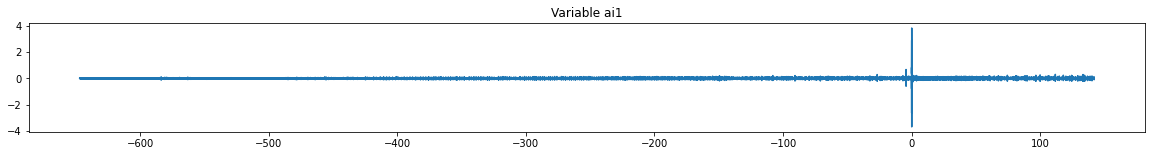

In [3]:
load_and_plot("./data/Ramp5/", "ai1")

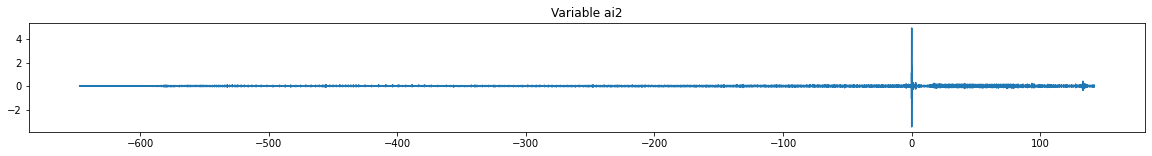

In [4]:
load_and_plot("./data/Ramp5/", "ai2")

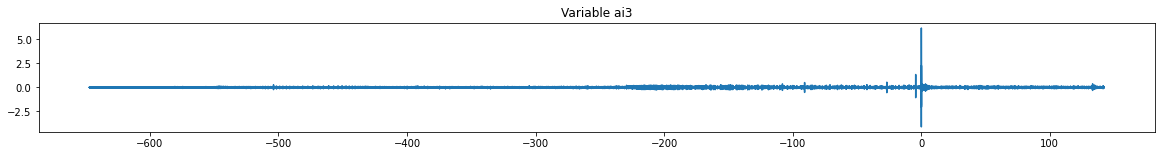

In [3]:
load_and_plot("./data/Ramp5/", "ai3")

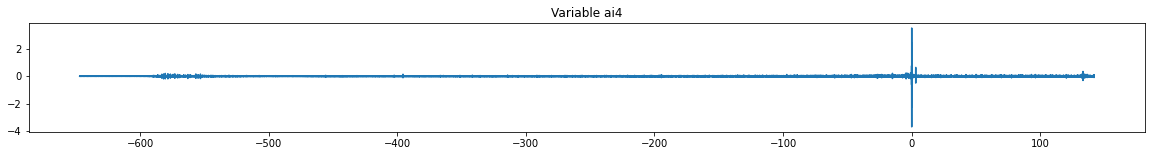

In [3]:
load_and_plot("./data/Ramp5/", "ai4")

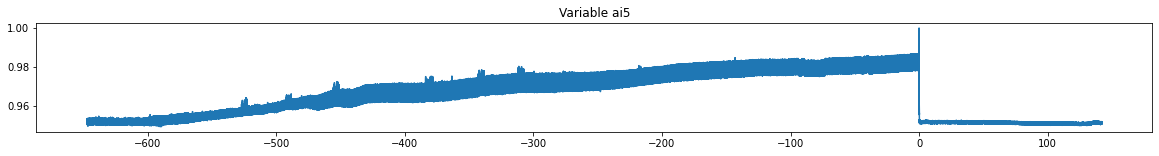

In [3]:
load_and_plot("./data/Ramp5/", "ai5")

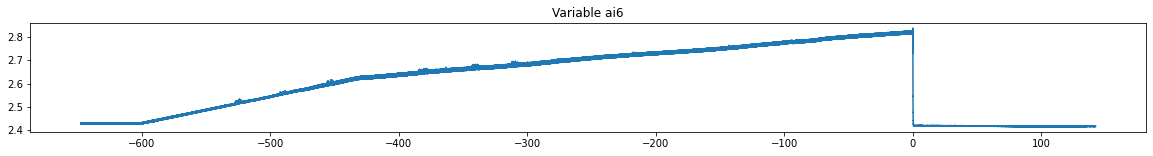

In [3]:
load_and_plot("./data/Ramp5/", "ai6")

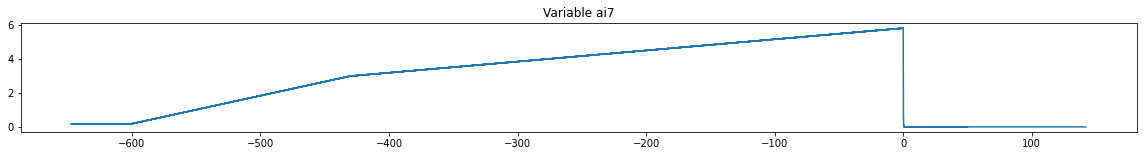

In [3]:
load_and_plot("./data/Ramp5/", "ai7")

### Experiment 1: Auto-encoding and anomaly detection for reconstruction loss. 

**General Idea:** Have a deep learning model to encode the data (and its corresponding satistics) and try to reconstruct it. The main objective when training the model would be to minimize the loss. Then, when processing real-time data, we set a threshold for the reconstruction loss, and if the loss goes over the threshold, then the model will trigger.

**Genral steps:**

1. Process the data (assume that (-1,500ms) is regular ramping and (-500ms,0) is test data)

2. Have the model learns to encode regular ramping data and minimize the reconstruction loss from a variable and its moving average, variance, kurtosis. 

3. Set the threshold for triggering, record the time when triggering. 

4. Then plot the distribution of the time triggering for different quenches.

**Detailed implementation:**

1. Transform the data of a specific variable into the form [sample_index, channels (raw, max, min, average, variance, kurtosis), value of each channel]

2. Build a CNN and minimize the reconstruction loss. 


### 1.1 Tranform data

In [5]:
import random
from random import randrange
random.seed(42)

In [6]:
def transform_data(quench_data, variable, window=50, sample_size=128):
    data = quench_data[[variable, 'time']].copy(deep=True)
    data['moving_average'] = data.loc[:, variable].rolling(window=window).mean()
    data['moving_max'] = data.loc[:, variable].rolling(window=window).max()
    data['moving_min'] = data.loc[:, variable].rolling(window=window).min()
    data['variance'] = data.loc[:, variable].rolling(window=window).std()
    data['kurtosis'] = data.loc[:, variable].rolling(window=window).kurt()
    
    data.dropna(inplace=True)
    
    time_label = data['time'].copy(deep=True).to_numpy()
    X_data = data[[variable, 'moving_average', 'variance', 'kurtosis', 'moving_max', 'moving_min']].copy(deep=True).to_numpy().transpose()
    
    X = []
    
    #Use a "sliding window" to collect the samples
    for i in reversed(range(sample_size, X_data.shape[1]+1)):
        X.append(X_data[:, i-sample_size:i].transpose())
    
    X = np.asarray(X)
    
   
    #Pick out the time for each sample
    time_label = time_label[sample_size-1:]
    
    print("X's shape: ", X.shape)
    print("time label's shape", time_label.shape)
    
    assert(X.shape[0] == time_label.shape[0])
    
    return X, time_label

def random_snapshot(quench_data, variable, num_samples, window=50, sample_size=128):
    data = quench_data[[variable]].copy(deep=True)
    data['moving_average'] = data.loc[:, variable].rolling(window=window).mean()
    data['moving_max'] = data.loc[:, variable].rolling(window=window).max()
    data['moving_min'] = data.loc[:, variable].rolling(window=window).min()
    data['variance'] = data.loc[:, variable].rolling(window=window).std()
    data['kurtosis'] = data.loc[:, variable].rolling(window=window).kurt()
    
    data.dropna(inplace=True)
    X_data = data[[variable, 'moving_average', 'variance', 'kurtosis', 'moving_max', 'moving_min']].copy(deep=True).to_numpy().transpose()
    
    X = []
    
    #Random snapshot
    for i in range(num_samples):
        j = randrange(sample_size, X_data.shape[1])
        X.append(X_data[:, j-sample_size:j].transpose())
    
    X = np.asarray(X)

    
    print("X's shape: ", X.shape)
    
    
    return X

In [7]:
#Get the data from non-quench signals
quench_data = mqxfs1d['mqxfs1d.Quench.180524152407']

V1_VoAqdHcoilHcoilM_1


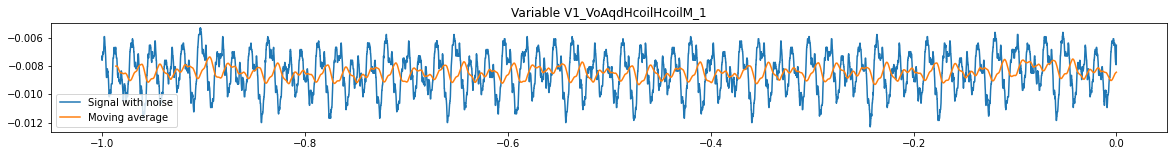

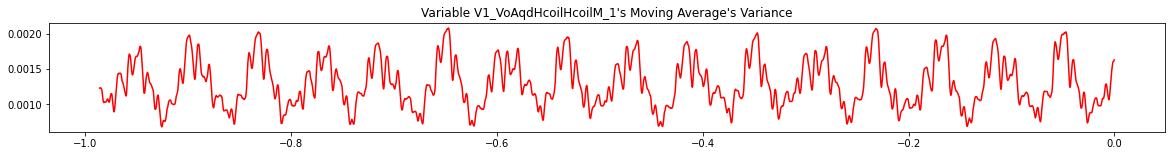

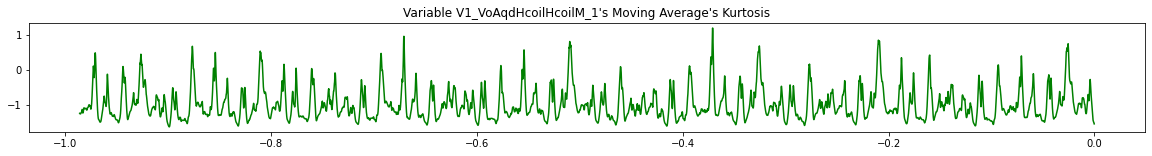

In [9]:
plot_statistics(quench_data, variables=["V1_VoAqdHcoilHcoilM_1"], time_range = (-1,0))

In [10]:
# Variable:  V1_VoTapSlbsNegM_1
train_data = quench_data[(quench_data["time"] > -1.0) & (quench_data["time"] < 0)]
#val_data = quench_data[(quench_data["time"] > -500e-3) & (quench_data["time"] < -1e-3)]

In [24]:
X_train = random_snapshot(train_data, variable = "V1_VoAqdHcoilHcoilM_1",
                          num_samples=6000, window=50, sample_size = 50)
#X_val, val_time_label = transform_data(val_data, variable = "V1_VoAqdHcoilHcoilM_1", window=50, sample_size = 128)

X's shape:  (6000, 50, 6)


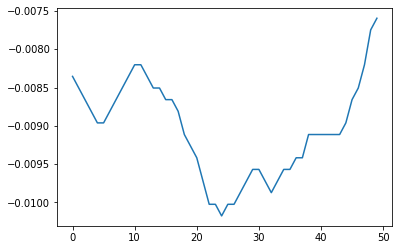

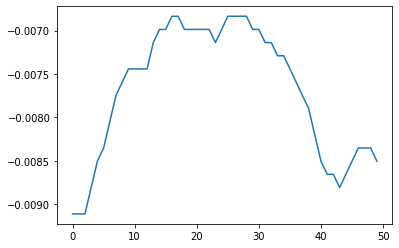

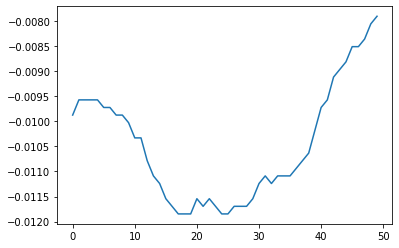

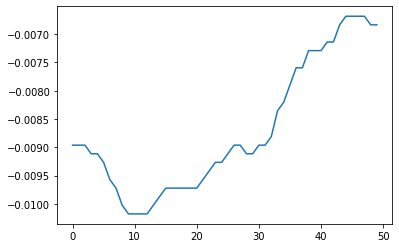

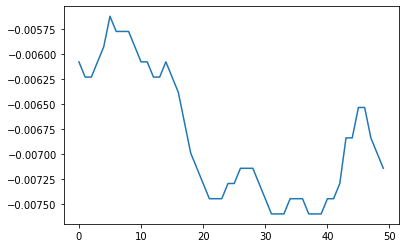

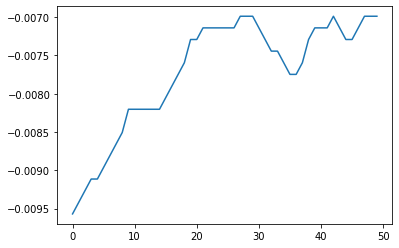

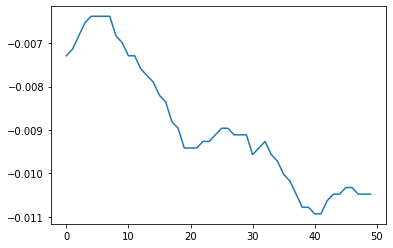

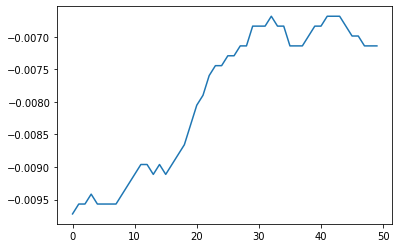

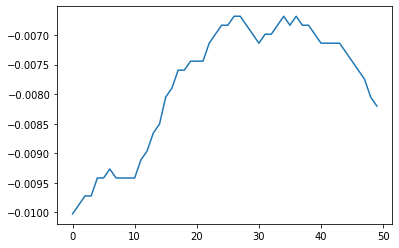

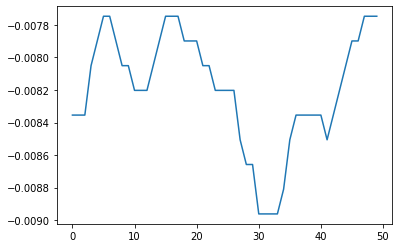

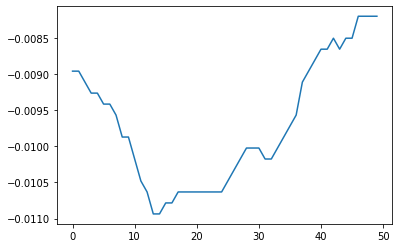

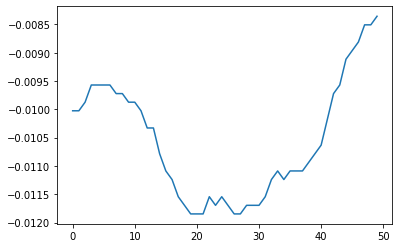

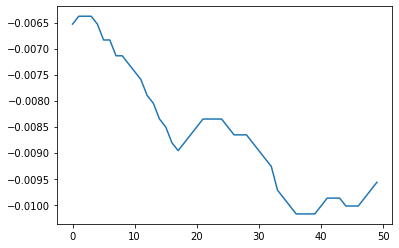

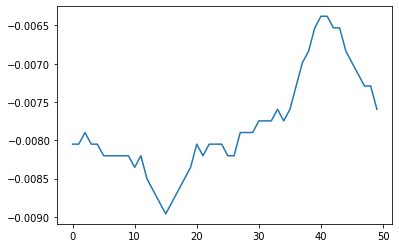

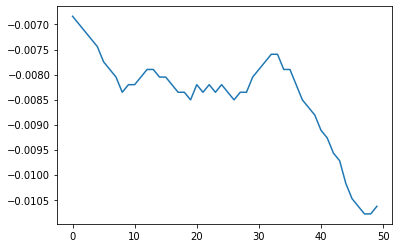

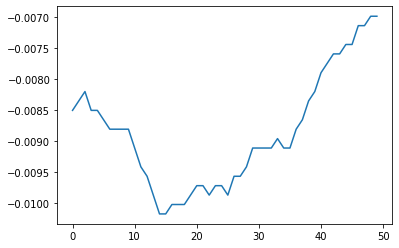

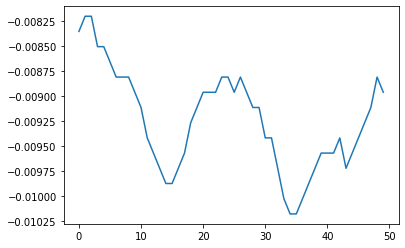

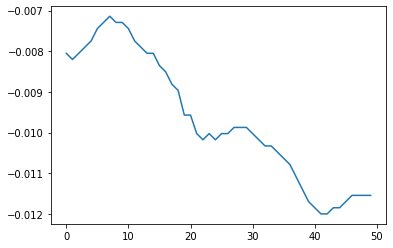

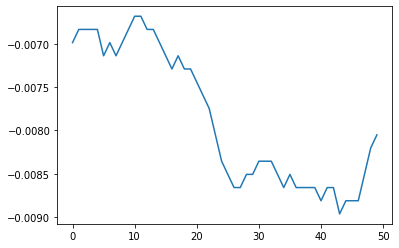

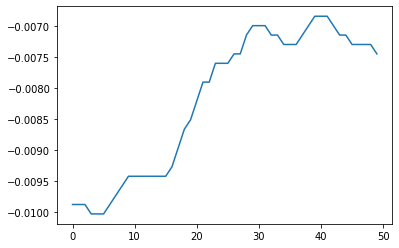

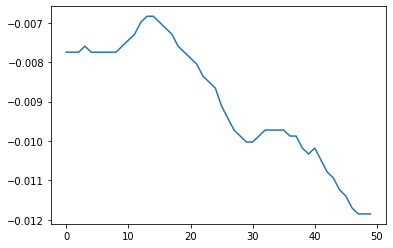

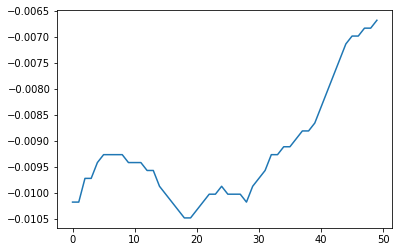

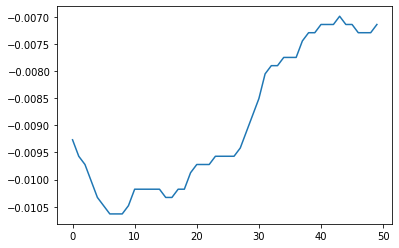

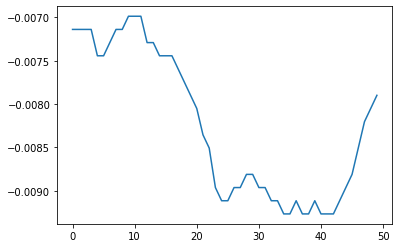

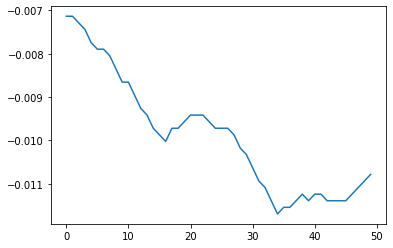

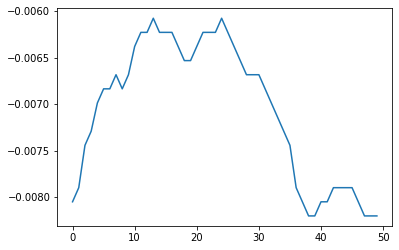

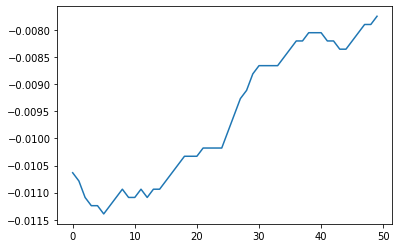

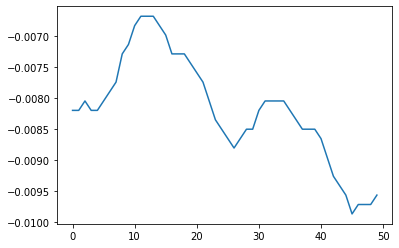

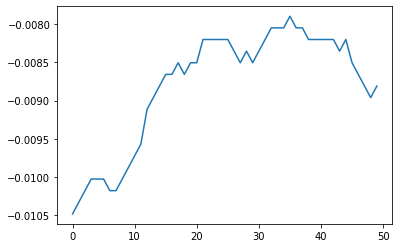

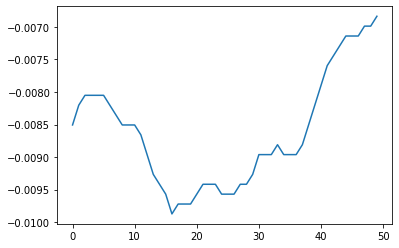

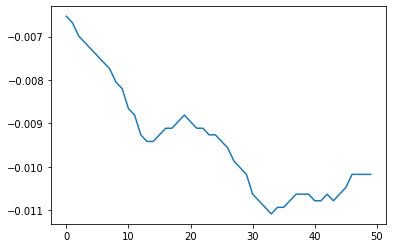

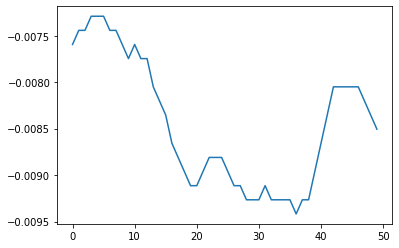

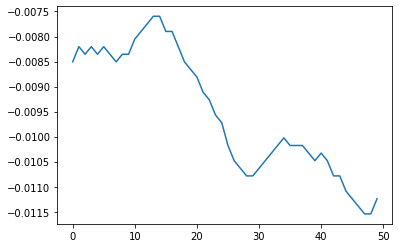

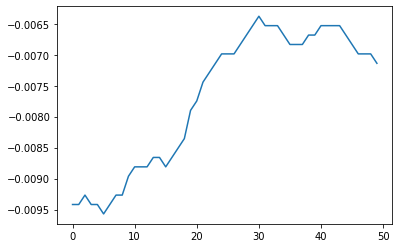

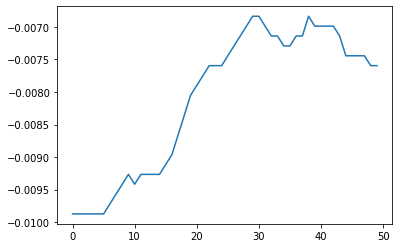

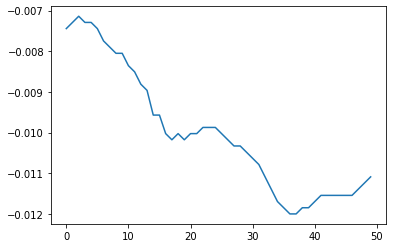

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [25]:
for i in range(X_train.shape[0]):
    plt.plot(X_train[i,:,0])
    plt.show()

### 1.2 Build the model

In [26]:
import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras import regularizers
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import UpSampling1D
import keras.layers as layers

In [28]:
#================BUILD THE MODEL====================
input_shape = X_train.shape[1:]
print("Input shape: ", input_shape)
print("Using Keras version: ", keras.__version__)

# Conv1d model
model = models.Sequential()

#Encoder
model.add(Conv1D(3, 8, activation='elu', padding = "same", kernel_initializer='glorot_uniform', input_shape=input_shape))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(20, activation='elu', kernel_initializer='he_normal'))
model.add(Dense(75, activation='elu', kernel_initializer='he_normal'))
model.add(Reshape((25,3)))

#Decoder
model.add(UpSampling1D(2))
model.add(Conv1D(3, 8, activation='elu', padding = "same", kernel_initializer='glorot_uniform'))


#Recontruct input
model.add(Conv1D(6, 1, activation='elu', padding = "same", kernel_initializer='glorot_uniform'))

model.compile(loss='mse', optimizer="adam")
model.summary()

Input shape:  (50, 6)
Using Keras version:  2.3.1
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 50, 3)             147       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 25, 3)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 75)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1520      
_________________________________________________________________
dense_6 (Dense)              (None, 75)                1575      
_________________________________________________________________
reshape_3 (Reshape)          (None, 25, 3)             0         
_________________________________________________________________
up_s

In [29]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=100

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 5400 samples, validate on 600 samples
Epoch 1/50
5400/5400 [==============================] - 3s 532us/step - loss: 0.2140 - val_loss: 0.1784
Epoch 2/50
5400/5400 [==============================] - 1s 272us/step - loss: 0.1495 - val_loss: 0.1207
Epoch 3/50
5400/5400 [==============================] - 1s 237us/step - loss: 0.0974 - val_loss: 0.0744
Epoch 4/50
5400/5400 [==============================] - 1s 239us/step - loss: 0.0620 - val_loss: 0.0538
Epoch 5/50
5400/5400 [==============================] - 1s 255us/step - loss: 0.0490 - val_loss: 0.0451
Epoch 6/50
5400/5400 [==============================] - 2s 283us/step - loss: 0.0420 - val_loss: 0.0393
Epoch 7/50
5400/5400 [==============================] - 2s 288us/step - loss: 0.0371 - val_loss: 0.0351
Epoch 8/50
5400/5400 [==============================] - 2s 288us/step - loss: 0.0336 - val_loss: 0.0320
Epoch 9/50
5400/5400 [==============================] - 1s 263us/step - loss: 0.0309 - val_loss: 0.0297
Epoch 10/50
5400/

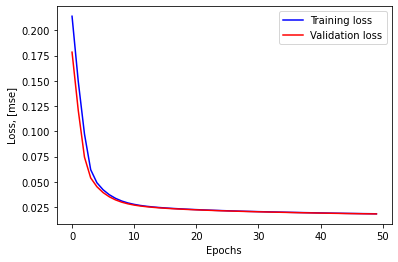

In [30]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

In [31]:
#Now predict on real quench data
test_quench_data = mqxfs1d['mqxfs1d.Quench.180424143318']

#test_data = test_quench_data[(test_quench_data["time"] > -1.0) & (test_quench_data["time"] < -5e-3)]

V1_VoAqdHcoilHcoilM_1


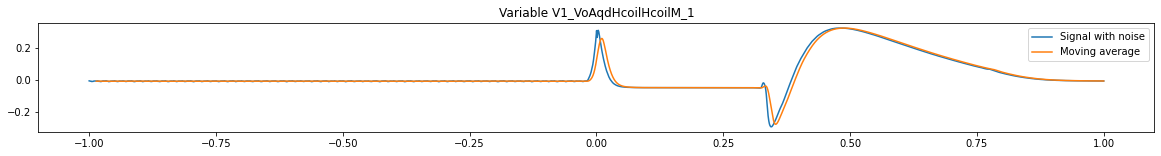

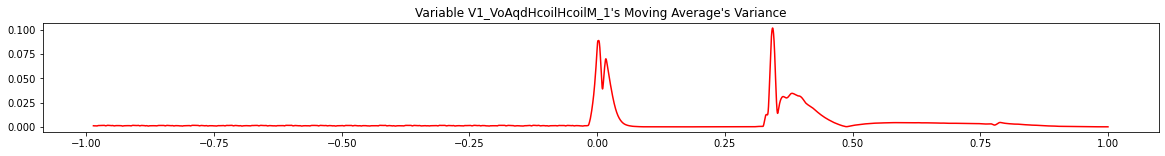

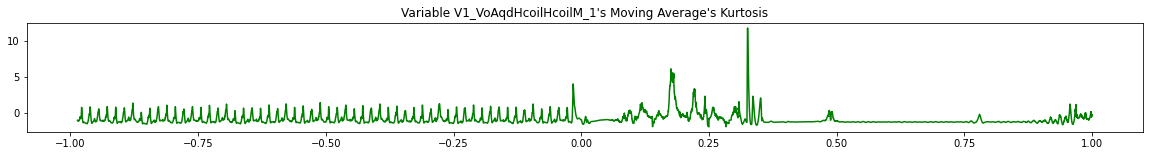

In [32]:
plot_statistics(test_quench_data, variables=["V1_VoAqdHcoilHcoilM_1"], time_range = (-1,1))

In [33]:
X_test, test_time_label = transform_data(test_quench_data, variable = "V1_VoAqdHcoilHcoilM_1",
                                        window=50, sample_size = 50)

X's shape:  (14186, 50, 6)
time label's shape (14186,)


In [34]:
score = []

for i in range(X_test.shape[0]):
    sample = X_test[i:i+1]
    score.append(model.evaluate(sample, sample, verbose = 0))
                
score = np.asarray(list(reversed(score)))

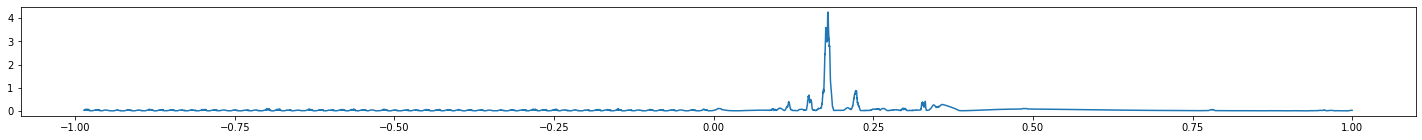

In [35]:
plt.figure(figsize=(25,2))
plt.plot(test_time_label, score)

### Try on simpler data & model

In [18]:
def transform_data(quench_data, variable, window=50, sample_size=128):
    data = quench_data[[variable, 'time']].copy(deep=True)
    
    data.dropna(inplace=True)
    
    time_label = data['time'].copy(deep=True).to_numpy()
    X_data = data[[variable]].copy(deep=True).to_numpy().transpose()
    
    X = []
    
    #Use a "sliding window" to collect the samples
    for i in reversed(range(sample_size, X_data.shape[1]+1)):
        X.append(X_data[:, i-sample_size:i].transpose())
    
    X = np.asarray(X)
    
   
    #Pick out the time for each sample
    time_label = time_label[sample_size-1:]
    
    X = X[:,:,0]
    
    print("X's shape: ", X.shape)
    print("time label's shape", time_label.shape)
    
    
    
    assert(X.shape[0] == time_label.shape[0])
    
    return X, time_label

def random_snapshot(quench_data, variable, num_samples, window=50, sample_size=128):
    data = quench_data[[variable]].copy(deep=True)
    
    data.dropna(inplace=True)
    X_data = data[[variable]].copy(deep=True).to_numpy().transpose()
    
    X = []
    
    #Random snapshot
    for i in range(num_samples):
        j = randrange(sample_size, X_data.shape[1])
        X.append(X_data[:, j-sample_size:j].transpose())
    
    X = np.asarray(X)
    
    X = X[:,:,0]
    
    print("X's shape: ", X.shape)
    
    
    return X

In [19]:
#Get the data from non-quench signals
quench_data = mqxfs1d['mqxfs1d.Quench.180524152407']

In [20]:
# Variable:  V1_VoTapSlbsNegM_1
train_data = quench_data[(quench_data["time"] > -1.0) & (quench_data["time"] < -13e-3)]
#val_data = quench_data[(quench_data["time"] > -500e-3) & (quench_data["time"] < -1e-3)]

In [21]:
X_train = random_snapshot(train_data, variable = "V1_VoAqdHcoilHcoilM_1",
                          num_samples=7000, window=50, sample_size = 600)
#X_val, val_time_label = transform_data(val_data, variable = "V1_VoAqdHcoilHcoilM_1", window=50, sample_size = 128)

X's shape:  (7000, 600)


In [24]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(128, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(64,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(128,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               76928     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 600)               77400     
Total params: 170,904
Trainable params: 170,904
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=100

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 6300 samples, validate on 700 samples
Epoch 1/50
6300/6300 [==============================] - 2s 316us/step - loss: 1.0488e-05 - val_loss: 2.3501e-06
Epoch 2/50
6300/6300 [==============================] - 1s 108us/step - loss: 2.1614e-06 - val_loss: 2.0333e-06
Epoch 3/50
6300/6300 [==============================] - 1s 126us/step - loss: 1.9673e-06 - val_loss: 1.9027e-06
Epoch 4/50
6300/6300 [==============================] - 1s 98us/step - loss: 1.8392e-06 - val_loss: 1.7740e-06
Epoch 5/50
6300/6300 [==============================] - 1s 111us/step - loss: 1.7235e-06 - val_loss: 1.6555e-06
Epoch 6/50
6300/6300 [==============================] - 1s 124us/step - loss: 1.6040e-06 - val_loss: 1.5320e-06
Epoch 7/50
6300/6300 [==============================] - 1s 102us/step - loss: 1.4678e-06 - val_loss: 1.3896e-06
Epoch 8/50
6300/6300 [==============================] - 1s 116us/step - loss: 1.3230e-06 - val_loss: 1.2393e-06
Epoch 9/50
6300/6300 [==============================] - 1s

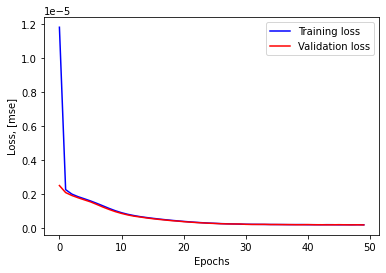

In [134]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

In [61]:
mqxfs1d.keys()

dict_keys(['mqxfs1d.Quench.180424143318', 'mqxfs1d.Quench.180424164614', 'mqxfs1d.Quench.180425123542', 'mqxfs1d.Quench.180425153748', 'mqxfs1d.Quench.180425182230', 'mqxfs1d.Quench.180426092221', 'mqxfs1d.Quench.180426115953', 'mqxfs1d.Quench.180426144623', 'mqxfs1d.Quench.180426171925', 'mqxfs1d.Quench.180427094832', 'mqxfs1d.Quench.180427124901', 'mqxfs1d.Quench.180427154529', 'mqxfs1d.Quench.180427184338', 'mqxfs1d.Quench.180501130547', 'mqxfs1d.Quench.180501160920', 'mqxfs1d.Quench.180502104142', 'mqxfs1d.Quench.180502143239', 'mqxfs1d.Quench.180503174053', 'mqxfs1d.Quench.180524152407', 'mqxfs1d.Quench.180524165335', 'mqxfs1d.Quench.180525093547', 'mqxfs1d.Quench.180525125034', 'mqxfs1d.Quench.180525172022', 'mqxfs1d.Quench.180529123355', 'mqxfs1d.Quench.180529153341', 'mqxfs1d.Quench.180529180450', 'mqxfs1d.Quench.180531114534', 'mqxfs1d.Quench.180531182410', 'mqxfs1d.Quench.180604121444', 'mqxfs1d.Quench.180604152848'])

In [26]:
#Now predict on real quench data
test_quench_data = mqxfs1d['mqxfs1d.Quench.180424143318']

test_data = test_quench_data[(test_quench_data["time"] > -1.0) & (test_quench_data["time"] < -5e-3)]

In [27]:
X_test, test_time_label = transform_data(test_data, variable = "V1_VoAqdHcoilHcoilM_1",
                                        window=50, sample_size = 600)


X's shape:  (6507, 600)
time label's shape (6507,)


In [28]:
score = []

for i in range(X_test.shape[0]):
    sample = X_test[i:i+1]
    score.append(model.evaluate(sample, sample, verbose = 0))
                
score = np.asarray(list(reversed(score)))

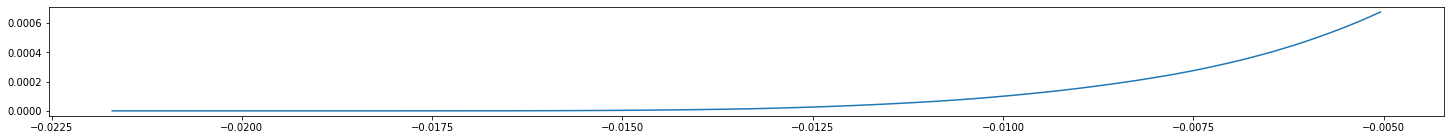

In [34]:
plt.figure(figsize=(25,2))
plt.plot(test_time_label[-120:], score[-120:])

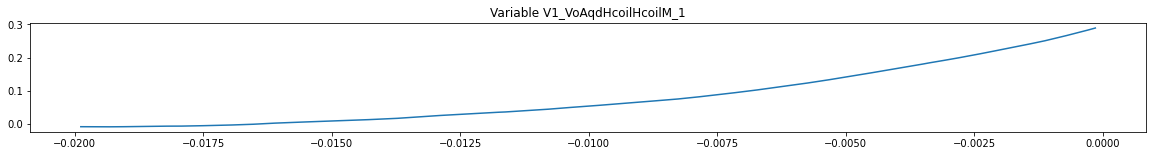

In [35]:
plot_variables_with_time(mqxfs1d['mqxfs1d.Quench.180424143318'], variables=["V1_VoAqdHcoilHcoilM_1"], time_range=(-20e-3,0))